<a href="https://colab.research.google.com/github/panghanwu/pytorch_example/blob/main/bicycle_sharing_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.optim as optim


In [2]:
data_path = 'hour.csv'
rides = pd.read_csv(data_path)
rides

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61


In [3]:
"""One hot"""

dummy_columns = [
    'season',
    'weathersit',
    'mnth',
    'hr',
    'weekday'
]

for each in dummy_columns:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

columns_to_drop = [
    'instant', 
    'dteday', 
    'season', 
    'weathersit',
    'weekday',
    'atemp',
    'mnth',
    'workingday',
    'hr' 
] 

data = rides.drop(columns_to_drop, axis=1)
data

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,season_3,season_4,weathersit_1,weathersit_2,weathersit_3,weathersit_4,mnth_1,mnth_2,mnth_3,mnth_4,mnth_5,mnth_6,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12,hr_0,hr_1,hr_2,hr_3,hr_4,hr_5,hr_6,hr_7,hr_8,hr_9,hr_10,hr_11,hr_12,hr_13,hr_14,hr_15,hr_16,hr_17,hr_18,hr_19,hr_20,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0000,3,13,16,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0000,8,32,40,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0000,5,27,32,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0000,3,10,13,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0000,0,1,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,1,0,0.26,0.60,0.1642,11,108,119,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
17375,1,0,0.26,0.60,0.1642,8,81,89,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
17376,1,0,0.26,0.60,0.1642,7,83,90,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
17377,1,0,0.26,0.56,0.1343,13,48,61,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0


In [4]:
"""Normalization"""

quant_features = [
    'cnt',
    'temp',
    'hum',
    'windspeed'
]

scaled_features = {}

for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data[each] = (data[each] - mean) / std

data

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,season_3,season_4,weathersit_1,weathersit_2,weathersit_3,weathersit_4,mnth_1,mnth_2,mnth_3,mnth_4,mnth_5,mnth_6,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12,hr_0,hr_1,hr_2,hr_3,hr_4,hr_5,hr_6,hr_7,hr_8,hr_9,hr_10,hr_11,hr_12,hr_13,hr_14,hr_15,hr_16,hr_17,hr_18,hr_19,hr_20,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,-1.334609,0.947345,-1.553844,3,13,-0.956312,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,-1.438475,0.895513,-1.553844,8,32,-0.823998,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,-1.438475,0.895513,-1.553844,5,27,-0.868103,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,-1.334609,0.636351,-1.553844,3,10,-0.972851,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,-1.334609,0.636351,-1.553844,0,1,-1.039008,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,1,0,-1.230743,-0.141133,-0.211685,11,108,-0.388467,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
17375,1,0,-1.230743,-0.141133,-0.211685,8,81,-0.553859,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
17376,1,0,-1.230743,-0.141133,-0.211685,7,83,-0.548346,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
17377,1,0,-1.230743,-0.348463,-0.456086,13,48,-0.708224,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0


In [5]:
"""Train-test split"""

# training data
train_data = data[:-21*24]
target_list = ['cnt', 'casual', 'registered']

features = train_data.drop(target_list, axis=1)
targets  = train_data[target_list]

# testing data
test_data = data[-21*24:]
test_features = test_data.drop(target_list, axis=1)
test_targets  = test_data[target_list]

# transfer to numpy
x = features.values
y = targets['cnt'].values
y = y.astype(float)

y = np.reshape(y, [len(y),1])
losses = []

print(x.shape, y.shape)

(16875, 56) (16875, 1)


In [6]:
"""Build neural network"""

input_size  = features.shape[1]
hidden_size = 10
output_size = 1
batch_size  = 128

neu = torch.nn.Sequential(
    torch.nn.Linear(input_size, hidden_size),
    torch.nn.Sigmoid(),
    torch.nn.Linear(hidden_size, output_size)
)

cost = torch.nn.MSELoss()
optimizer = torch.optim.SGD(neu.parameters(), lr=0.01)

print(neu)

Sequential(
  (0): Linear(in_features=56, out_features=10, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=10, out_features=1, bias=True)
)


Epoch0 0.8920353
Epoch500 0.08272301
Epoch1000 0.06554938
Epoch1500 0.059687313
Epoch2000 0.05722556
Epoch2500 0.05598685
Epoch3000 0.05496434
Epoch3500 0.05411554
Epoch4000 0.05342487
Epoch4500 0.052872267


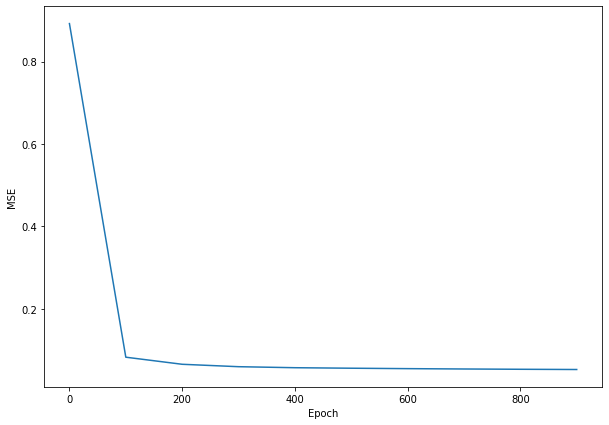

In [7]:
"""Train model"""

losses = []
for i in range(5000):
    batch_loss = []

    for start in range(0, len(x), batch_size):
        end = start + batch_size if start+batch_size < len(x) else len(x)
        xx = torch.tensor(x[start:end], requires_grad=True).float()
        yy = torch.tensor(y[start:end], requires_grad=True).float()
        predict = neu(xx)
        loss = cost(predict, yy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.data.numpy())
        
    if i%500 == 0:
        losses.append(np.mean(batch_loss))
        print('Epoch'+str(i), np.mean(batch_loss))

# plot
plt.figure(figsize=(10,7))
plt.plot(np.arange(len(losses))*100, losses)
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.show()

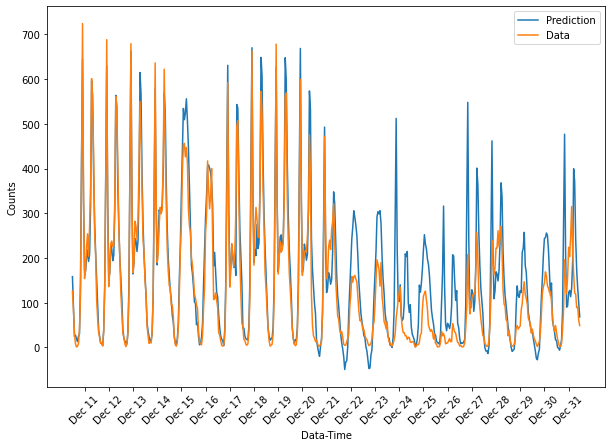

In [8]:
"""Testing"""

targets = test_targets['cnt']
targets = targets.values.reshape([len(targets), 1])

targets = targets.astype(float)

x = torch.tensor(test_features.values).float()
y = torch.tensor(targets).float()

predict = neu(x)
predict = predict.data.numpy()

# plot
fig, ax = plt.subplots(figsize=(10,7))

mean, std = scaled_features['cnt']
ax.plot(predict * std + mean, label='Prediction')
ax.plot(targets * std + mean, label='Data')
ax.legend()
ax.set_xlabel('Data-Time')
ax.set_ylabel('Counts')

dates = pd.to_datetime(rides.loc[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
ax.set_xticklabels(dates[12::24], rotation=45)

plt.show()

In [9]:
np.arange(100)[0::15]

array([ 0, 15, 30, 45, 60, 75, 90])

In [10]:
"""Explanation"""

def feature(x, net):
    x = torch.from_numpy(x).type(torch.float)
    
    dic = dict(net.named_parameters())
    weights = dic['0.weight']
    biases  = dic['0.bias']
    h = torch.sigmoid(x.mm(weights.t())+biases.expand([len(x), len(biases)]))
    return h 

# get 3 days
bool1 = rides['dteday'] == '2012-12-22'
bool2 = rides['dteday'] == '2012-12-23'
bool3 = rides['dteday'] == '2012-12-24'

bools = [any(tup) for tup in zip(bool1,bool2,bool3)]
subset = test_features.loc[rides[bools].index]
subtargets = test_targets.loc[rides[bools].index]
subtargets = subtargets['cnt']
subtargets = subtargets.values.reshape([len(subtargets),1])



rides[bools].index

Int64Index([17141, 17142, 17143, 17144, 17145, 17146, 17147, 17148, 17149,
            17150, 17151, 17152, 17153, 17154, 17155, 17156, 17157, 17158,
            17159, 17160, 17161, 17162, 17163, 17164, 17165, 17166, 17167,
            17168, 17169, 17170, 17171, 17172, 17173, 17174, 17175, 17176,
            17177, 17178, 17179, 17180, 17181, 17182, 17183, 17184, 17185,
            17186, 17187, 17188, 17189, 17190, 17191, 17192, 17193, 17194,
            17195, 17196, 17197, 17198, 17199, 17200, 17201, 17202, 17203,
            17204, 17205, 17206, 17207, 17208, 17209, 17210, 17211],
           dtype='int64')

In [11]:
results = feature(subset.values, neu).data.numpy()
predict = neu(torch.tensor(subset.values).float()).data.numpy()

mean, std = scaled_features['cnt']
predict = predict * std + mean
subtargets = subtargets * std + mean

p = (predict - min(predict)) / (max(predict) - min(predict))
d = (subtargets - min(predict)) / (max(predict) - min(predict))

print(p.shape, d.shape)

(71, 1) (71, 1)


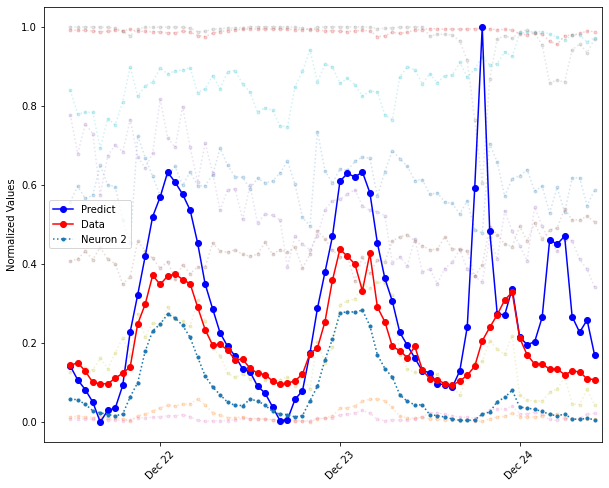

In [21]:
# plot
fig, ax = plt.subplots(figsize=(10,8))

ax.plot(results[:,:], '.:', alpha=.2)
ax.plot(p, 'bo-', label='Predict')
ax.plot(d, 'ro-', label='Data')

n = 2
ax.plot(results[:,n], '.:', alpha=1, label='Neuron '+str(n))

ax.set_xlim(right=len(predict))
ax.legend()
plt.ylabel('Normalized Values')

dates = pd.to_datetime(rides.loc[subset.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
ax.set_xticklabels(dates[12::24], rotation=45)

plt.show()

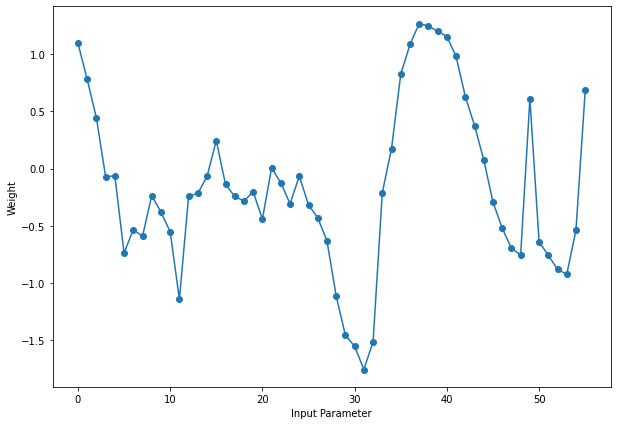

In [22]:
# get weights of Neuron 2
dic = dict(neu.named_parameters())
weights = dic['0.weight']

plt.figure(figsize=(10,7))
plt.plot(weights.data.numpy()[n,:], 'o-')
plt.xlabel('Input Parameter')  # correspond to columns
plt.ylabel('Weight')
plt.show()